# décrire le problème [TO DO]

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [15]:
class Dataset_1D(Dataset):
    def __init__(self, nb_points_in_omega, upper_bound=np.pi):
        self.nb_points_in_omega = nb_points_in_omega
        self.upper_bound = upper_bound
        self.points = torch.FloatTensor(np.linspace(0, np.pi, self.nb_points_in_omega)).reshape(self.nb_points_in_omega, 1)
        self.boundary_points = torch.FloatTensor([self.points[0], self.points[-1]]).reshape(2,1)
        self.labels = self._stratify_points(6)
           
    def __getitem__(self, index):   
        return self.points[index]
    
    def __len__(self):
        return self.nb_points_in_omega
    
    def _stratify_points(self, div):
        labels = np.zeros(self.nb_points_in_omega, dtype=int)
        quotient = self.nb_points_in_omega // div
        for i in range(div):
            if i!= div-1 :
                labels[i*quotient:(i+1)*quotient] = i
            else :
                labels[i*quotient:] = i
        return labels
    
def create_train_val_dataset(dataset, val_size=0.2):

    train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=val_size, random_state=6, stratify=dataset.labels)

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    return train_dataset, val_dataset

In [16]:
class ActivationCube(torch.nn.Module):
    def __init__(self) -> None:
        super(ActivationCube, self).__init__()

    def forward(self, x):
        return torch.maximum(x**3, torch.tensor(0.))

class RecurentBlock(torch.nn.Module):
    def __init__(self, hidden_size):
        super(RecurentBlock, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.activation1 = ActivationCube()
        self.fc2 = torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.activation2 = ActivationCube()
    
    def forward(self, x):
        retain_x = x
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = x + retain_x
        return x

class RitzModel(torch.nn.Module):

    def __init__(self, num_blocks=4, hidden_size=10):
        super(RitzModel, self).__init__()

        self.fc_in = torch.nn.Linear(1, hidden_size)
        self.blocks = torch.nn.ModuleList([RecurentBlock(hidden_size=hidden_size) for _ in range(num_blocks)])
        self.fc_out = torch.nn.Linear(hidden_size, 1)

        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self, x):
        
        x = self.fc_in(x)
        for block in self.blocks:
            x = block(x)
        u_theta = self.fc_out(x)

        return u_theta

In [17]:
model = RitzModel()
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

911


In [18]:
# TO CHANGE AFTER

class EarlyStopping:
    def __init__(self, patience=7, delta=0.) :
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.delta :
            self.counter += 1
        else :
            self.counter = 0
        if self.counter > self.patience :
            self.early_stop = True

In [19]:
def u_true(x):
    return np.sin(x)**2

def f_true(x):
    return np.sin(2*x) + 2*x*np.cos(2*x)

In [20]:
vxn  = 50
X = Dataset_1D(vxn)
ix = X.points

In [21]:
batch_size_train = 20
batch_size_val = 10
train_dataset, val_dataset = create_train_val_dataset(X, val_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

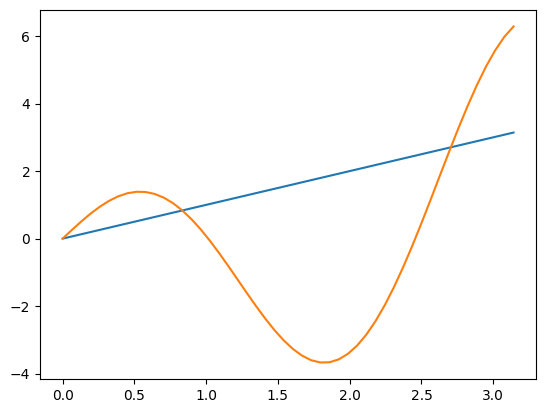

In [22]:
plt.plot(ix, ix)
plt.plot(ix, f_true(ix))

In [23]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.il  = torch.nn.Linear(1,80)
        self.mi  = torch.nn.Linear(80,80)
        self.mi1  = torch.nn.Linear(80,80)
        self.mi2 = torch.nn.Linear(80,40)
        self.ol  = torch.nn.Linear(40,1)

        self.tn  = torch.nn.Tanh()
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self,x):
        u = x
        hidden1 = self.il(u)
        hidden2 = self.mi(self.tn(hidden1))
        hidden2a = self.mi1(self.tn(hidden2))
        hidden3 = self.mi2(self.tn(hidden2a))
        out =  self.ol(self.tn(hidden3))
        return out

In [24]:
boundary = X.boundary_points
true_boundary = torch.FloatTensor([0., 0.]).reshape(2,1) # homogeneous boundary condition

pred_boundary_ritz = np.array([])
pred_boundary_net = np.array([])

ritz_model = RitzModel()
net_model = Net()

for _ in range(100) :
    pred_boundary_ritz = np.append(pred_boundary_ritz, ritz_model(boundary).detach().numpy())
    pred_boundary_net = np.append(pred_boundary_net, net_model(boundary).detach().numpy())

print(np.mean(pred_boundary_ritz), np.mean(pred_boundary_net))

0.28656844794750214 0.08104734122753143


In [25]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

def Du(x, model):
    u = model(x)
    u_x = grad(flat(u), x, create_graph=True, allow_unused=True)[0]
    z = u_x*x
    u_xx = grad(flat(z), x, create_graph=True, allow_unused=True)[0]
    return u_xx

In [188]:
# VERSION WITH DATALOADER

net_model = RitzModel()
total_params = sum(p.numel() for p in net_model.parameters())
print(total_params)

epochs = 1000
loss_fn = torch.nn.MSELoss()
optimizer_f = torch.optim.Adam(net_model.parameters(), lr=0.0005)
optimizer_boundary = torch.optim.Adam(net_model.parameters(), lr=0.001)

train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch_i in range(epochs):
    net_model.train()
    train_loss_epoch_i = 0

    for batch in train_loader:
        batch.requires_grad = True
        f_batch = torch.FloatTensor(f_true(batch.detach().numpy())).reshape(batch_size_train,1)
        f_batch.requires_grad = True

        optimizer_f.zero_grad()
        optimizer_boundary.zero_grad()

        output_boundary = net_model(X.boundary_points)
        output_f = Du(batch, net_model)

        loss_boundary = loss_fn(output_boundary, true_boundary)
        loss_f = loss_fn(output_f, f_batch)

        train_loss_epoch_i += loss_boundary.item() + loss_f.item()
        
        loss_f.backward()
        loss_boundary.backward()
        optimizer_f.step()
        optimizer_boundary.step()

    train_loss_per_epoch.append(train_loss_epoch_i / len(train_loader))

    net_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_val in val_loader:
            f_batch_val = torch.FloatTensor(f_true(batch_val.detach().numpy())).reshape(batch_size_val,1)
            val_loss += (net_model(batch_val) - f_batch_val)**2

    val_loss_per_epoch.append(val_loss.mean())
    # print(f"Epoch {epoch_i+1} : Validation Loss {val_loss}, Train loss {loss_boundary.item() + loss_f.item()}")

    # if epoch % 10 == 0 :
    #     print(f'Epoch {epoch} : Loss boundary {loss_boundary.item()} Loss f {loss_f.item()}')
        

911


In [203]:
# PINNS

from scipy.integrate import simps

net_model = RitzModel()
total_params = sum(p.numel() for p in net_model.parameters())
print(total_params)

epochs = 2000
loss_fn = torch.nn.MSELoss()
model_optimizer = torch.optim.Adam(net_model.parameters(), lr=0.0005)

train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch_i in range(epochs):
    net_model.train()
    train_loss_epoch_i = 0

    for batch in train_loader:
        batch.requires_grad = True
        f_batch = torch.FloatTensor(f_true(batch.detach().numpy())).reshape(batch_size_train,1)
        f_batch.requires_grad = True
        u_batch = torch.FloatTensor(u_true(batch.detach().numpy())).reshape(batch_size_train,1)
        u_batch.requires_grad = True

        model_optimizer.zero_grad()

        output_omega = net_model(batch)
        output_boundary = net_model(X.boundary_points)
        output_f = Du(batch, net_model)

        data_loss = loss_fn(output_omega, u_batch)
        physical_loss = loss_fn(output_f, f_batch)
        boundary_loss = loss_fn(output_boundary, true_boundary)

        train_loss_epoch_i += data_loss.item() + boundary_loss.item() + 1e6*physical_loss.item()

        data_loss.backward()
        physical_loss.backward()
        boundary_loss.backward()
        model_optimizer.step()

    train_loss_per_epoch.append(train_loss_epoch_i / len(train_loader))

    net_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_val in val_loader:
            f_batch_val = torch.FloatTensor(f_true(batch_val.detach().numpy())).reshape(batch_size_val,1)
            val_loss += (net_model(batch_val) - f_batch_val)**2

    val_loss_per_epoch.append(val_loss.mean())
    # print(f"Epoch {epoch_i+1} : Validation Loss {val_loss}, Train loss {loss_boundary.item() + loss_f.item()}")

    # if epoch % 10 == 0 :
    #     print(f'Epoch {epoch} : Loss boundary {loss_boundary.item()} Loss f {loss_f.item()}')
        

911


[1.347065e-05] [0.00356361] 0.0014922221


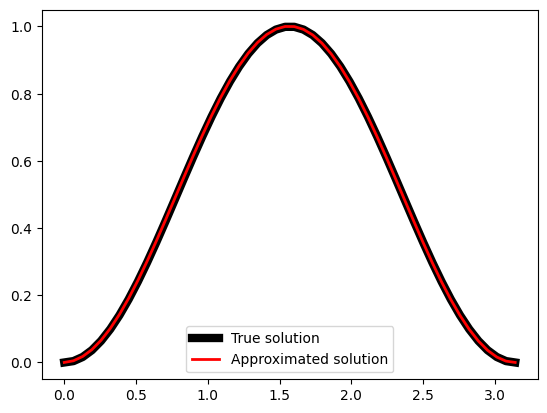

In [204]:
# ix = torch.FloatTensor(vx).reshape(vxn,1)
ix = torch.FloatTensor(np.linspace(0, np.pi, 50)).reshape(50, 1)
u = net_model(ix)
plt.plot(ix, u_true(ix) ,  linewidth=6, color='black', label='True solution')
plt.plot(ix, u.detach().numpy(), linewidth=2, color='red', label='Approximated solution')
plt.legend()
print(min(abs(u.detach().numpy() - u_true(ix).detach().numpy())), max(abs(u.detach().numpy() - u_true(ix).detach().numpy())), np.mean(abs(u.detach().numpy() - u_true(ix).detach().numpy())))

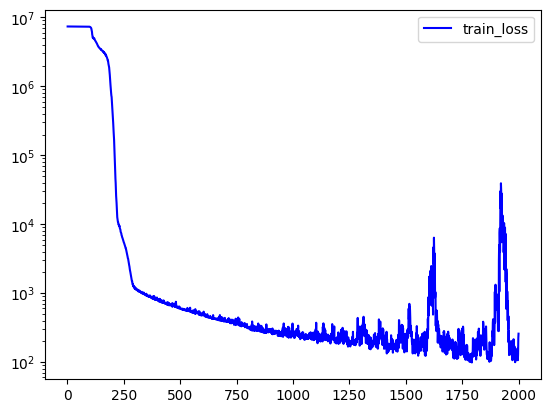

In [205]:
xx = np.linspace(1, epochs, epochs)
plt.plot(xx, train_loss_per_epoch, label = 'train_loss', color='blue')
# plt.plot(xx, val_loss_per_epoch, label = 'val_loss', color='red')
plt.yscale('log')
plt.legend()
plt.show()